In [1]:
%%capture
%pip install -U fashion-clip
%pip install -U scikit-learn
%pip install -U tqdm
%pip install -U opencv-python
%pip install -U pillow

In [2]:
import sys
import json
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [3]:
%%capture
fclip = FashionCLIP('fashion-clip')

In [4]:
# this code block tries to remove the model from an image and only render the item of clothing itself (lmao tries to)
import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# Load the image from the URL
image_url = "https://images.lululemon.com/is/image/lululemon/LM3FAES_019746_1"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Convert the image to a NumPy array and resize
img_np = np.array(img)

# Load the DeepLabV3 model with updated weights
weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet101(weights=weights).eval()

# Define mean and std for normalization (ImageNet values)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Preprocess the image for the model
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

input_tensor = preprocess(img).unsqueeze(0)

# Run the model on the input imagewith torch.no_grad():
output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Assuming class 'person' has index 15 in the COCO dataset
person_class = 15
mask = output_predictions == person_class

# Invert the mask to remove the person
clothing_mask = np.invert(mask)

# Apply the mask to keep only the clothing
clothing_only = img_np.copy()
clothing_only[mask] = [255, 255, 255]  # Replace the person pixels with white background# Convert back to image and save or display
clothing_only_img = Image.fromarray(clothing_only)
clothing_only_img.show()  # or save it using clothing_only_img.save('clothing_only.png')

KeyboardInterrupt: 

In [ ]:
import json
from fashion_clip.fashion_clip import FashionCLIP
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

# Load the Fashion-CLIP model
fclip = FashionCLIP('fashion-clip')

# Load your existing data
data_source = 'data/1000_items.json'
with open(data_source, 'r') as f:
    items = json.load(f)

# Prepare lists to store image URLs and product descriptions
image_urls = []
texts = []

# Extract image URLs and product descriptions
for item in items.values():
    if item['image_urls']:
        image_urls.append(item['image_urls'][0])  # Use the first image URL
    else:
        image_urls.append(None)
    
    # Combine product name and long description for text embedding
    text = f"name:{item['product_name']} description:{item['long_description']} price:{item['price']}"
    texts.append(text)

# Function to load image from URL
def load_image_from_url(url):
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Check if the content type is an image
        content_type = response.headers.get('Content-Type', '')
        if not content_type.startswith('image'):
            print(f"Error: URL does not point to an image. Content-Type: {content_type}")
            return None
        
        image_data = response.content
        
        # Try to determine the image format
        try:
            img = Image.open(BytesIO(image_data))
        except Exception as e:
            print(f"Error opening image: {e}")
            return None
        
        # Convert to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        return img
    except requests.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
    except Exception as e:
        print(f"Unexpected error loading image from {url}: {e}")
    
    return None

# Process images in batches
batch_size = 32
image_embeddings = []
failed_images = []

# Create a progress bar for image processing
total_images = len(image_urls)
with tqdm(total=total_images, desc="Processing images") as pbar:
    for i in range(0, total_images, batch_size):
        batch_urls = image_urls[i:i+batch_size]
        batch_images = [load_image_from_url(url) if url else None for url in batch_urls]
        
        # Filter out None values (failed image loads)
        valid_images = [img for img in batch_images if img is not None]
        
        if valid_images:
            try:
                batch_embeddings = fclip.encode_images(valid_images, batch_size=len(valid_images))
                image_embeddings.extend(batch_embeddings)
            except Exception as e:
                print(f"Error processing batch: {e}")
                image_embeddings.extend([np.zeros(512)] * len(valid_images))
                failed_images.extend([url for url, img in zip(batch_urls, batch_images) if img is not None])
        
        # Add zero embeddings for failed or missing images
        num_failed = len(batch_urls) - len(valid_images)
        image_embeddings.extend([np.zeros(512)] * num_failed)
        failed_images.extend([url for url, img in zip(batch_urls, batch_images) if img is None])
        
        # Update progress bar
        pbar.update(len(batch_urls))
        pbar.set_postfix({"Completed": f"{pbar.n}/{total_images} ({pbar.n/total_images:.1%})"})

image_embeddings = np.array(image_embeddings)

# Create text embeddings
text_embeddings = []
total_texts = len(texts)
with tqdm(total=total_texts, desc="Processing text") as pbar:
    for i in range(0, total_texts, batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = fclip.encode_text(batch_texts, batch_size=len(batch_texts))
        text_embeddings.extend(batch_embeddings)
        
        # Update progress bar
        pbar.update(len(batch_texts))
        pbar.set_postfix({"Completed": f"{pbar.n}/{total_texts} ({pbar.n/total_texts:.1%})"})

text_embeddings = np.array(text_embeddings)

# Normalize embeddings, handling zero vectors
def safe_normalize(embeddings):
    norms = np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    return embeddings / norms

image_embeddings = safe_normalize(image_embeddings)
text_embeddings = safe_normalize(text_embeddings)

# Add embeddings to items
print("Adding embeddings to items...")
for i, (key, item) in enumerate(tqdm(items.items())):
    item['image_embedding'] = image_embeddings[i].tolist()
    item['text_embedding'] = text_embeddings[i].tolist()

# Save updated items to JSON file
output_file = 'data/items_with_embeddings.json'
print(f"Saving items with embeddings to {output_file}...")
with open(output_file, 'w') as f:
    json.dump(items, f, indent=4)

print(f"Items with embeddings have been saved to {output_file}")

# Report on failed images
print(f"\nTotal failed images: {len(failed_images)}")
print("Failed image URLs:")
for url in failed_images:
    print(url)

# Verify embeddings
num_items = len(items)
num_image_embeddings = len(image_embeddings)
num_text_embeddings = len(text_embeddings)

print(f"\nVerification:")
print(f"Number of items: {num_items}")
print(f"Number of image embeddings: {num_image_embeddings}")
print(f"Number of text embeddings: {num_text_embeddings}")

if num_items == num_image_embeddings == num_text_embeddings:
    print("All counts match. Data integrity maintained.")
else:
    print("WARNING: Mismatch in counts. Please check the data.")

In [5]:
import numpy as np

# Load the embeddings from the saved JSON file
with open('data/items_with_embeddings.json', 'r') as f:
    items_with_embeddings = json.load(f)

# Extract image and text embeddings
image_embeddings = np.array([item['image_embedding'] for item in items_with_embeddings.values()])
text_embeddings = np.array([item['text_embedding'] for item in items_with_embeddings.values()])

precision = 0

# We could batch this operation to make it faster
for index, t in enumerate(text_embeddings):
    arr = t.dot(image_embeddings.T)
    best = arr.argsort()[-5:][::-1]
    if index in best:
        precision += 1

precision_score = round(precision / len(text_embeddings), 2)
print(f"Precision@5: {precision_score}")

Precision@5: 0.35


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

4it [00:01,  2.97it/s]                       


Item name: lululemon lab Lightweight Jacquard Jacket, Item image: https://images.lululemon.com/is/image/lululemon/LM3DRES_060006_1
Top 2 tags for each category:

Item types:
  jacket: 0.2847
  coat: 0.2670

Colors:
  navy: 0.2293
  coral: 0.2265

Materials:
  flannel: 0.2491
  cashmere: 0.2306

Patterns:
  printed: 0.2448
  floral: 0.2296

Styles:
  casual: 0.2444
  vintage: 0.2265

Features:
  pleated: 0.2230
  cropped: 0.2204

Occasions:
  workwear: 0.2671
  activewear: 0.2635


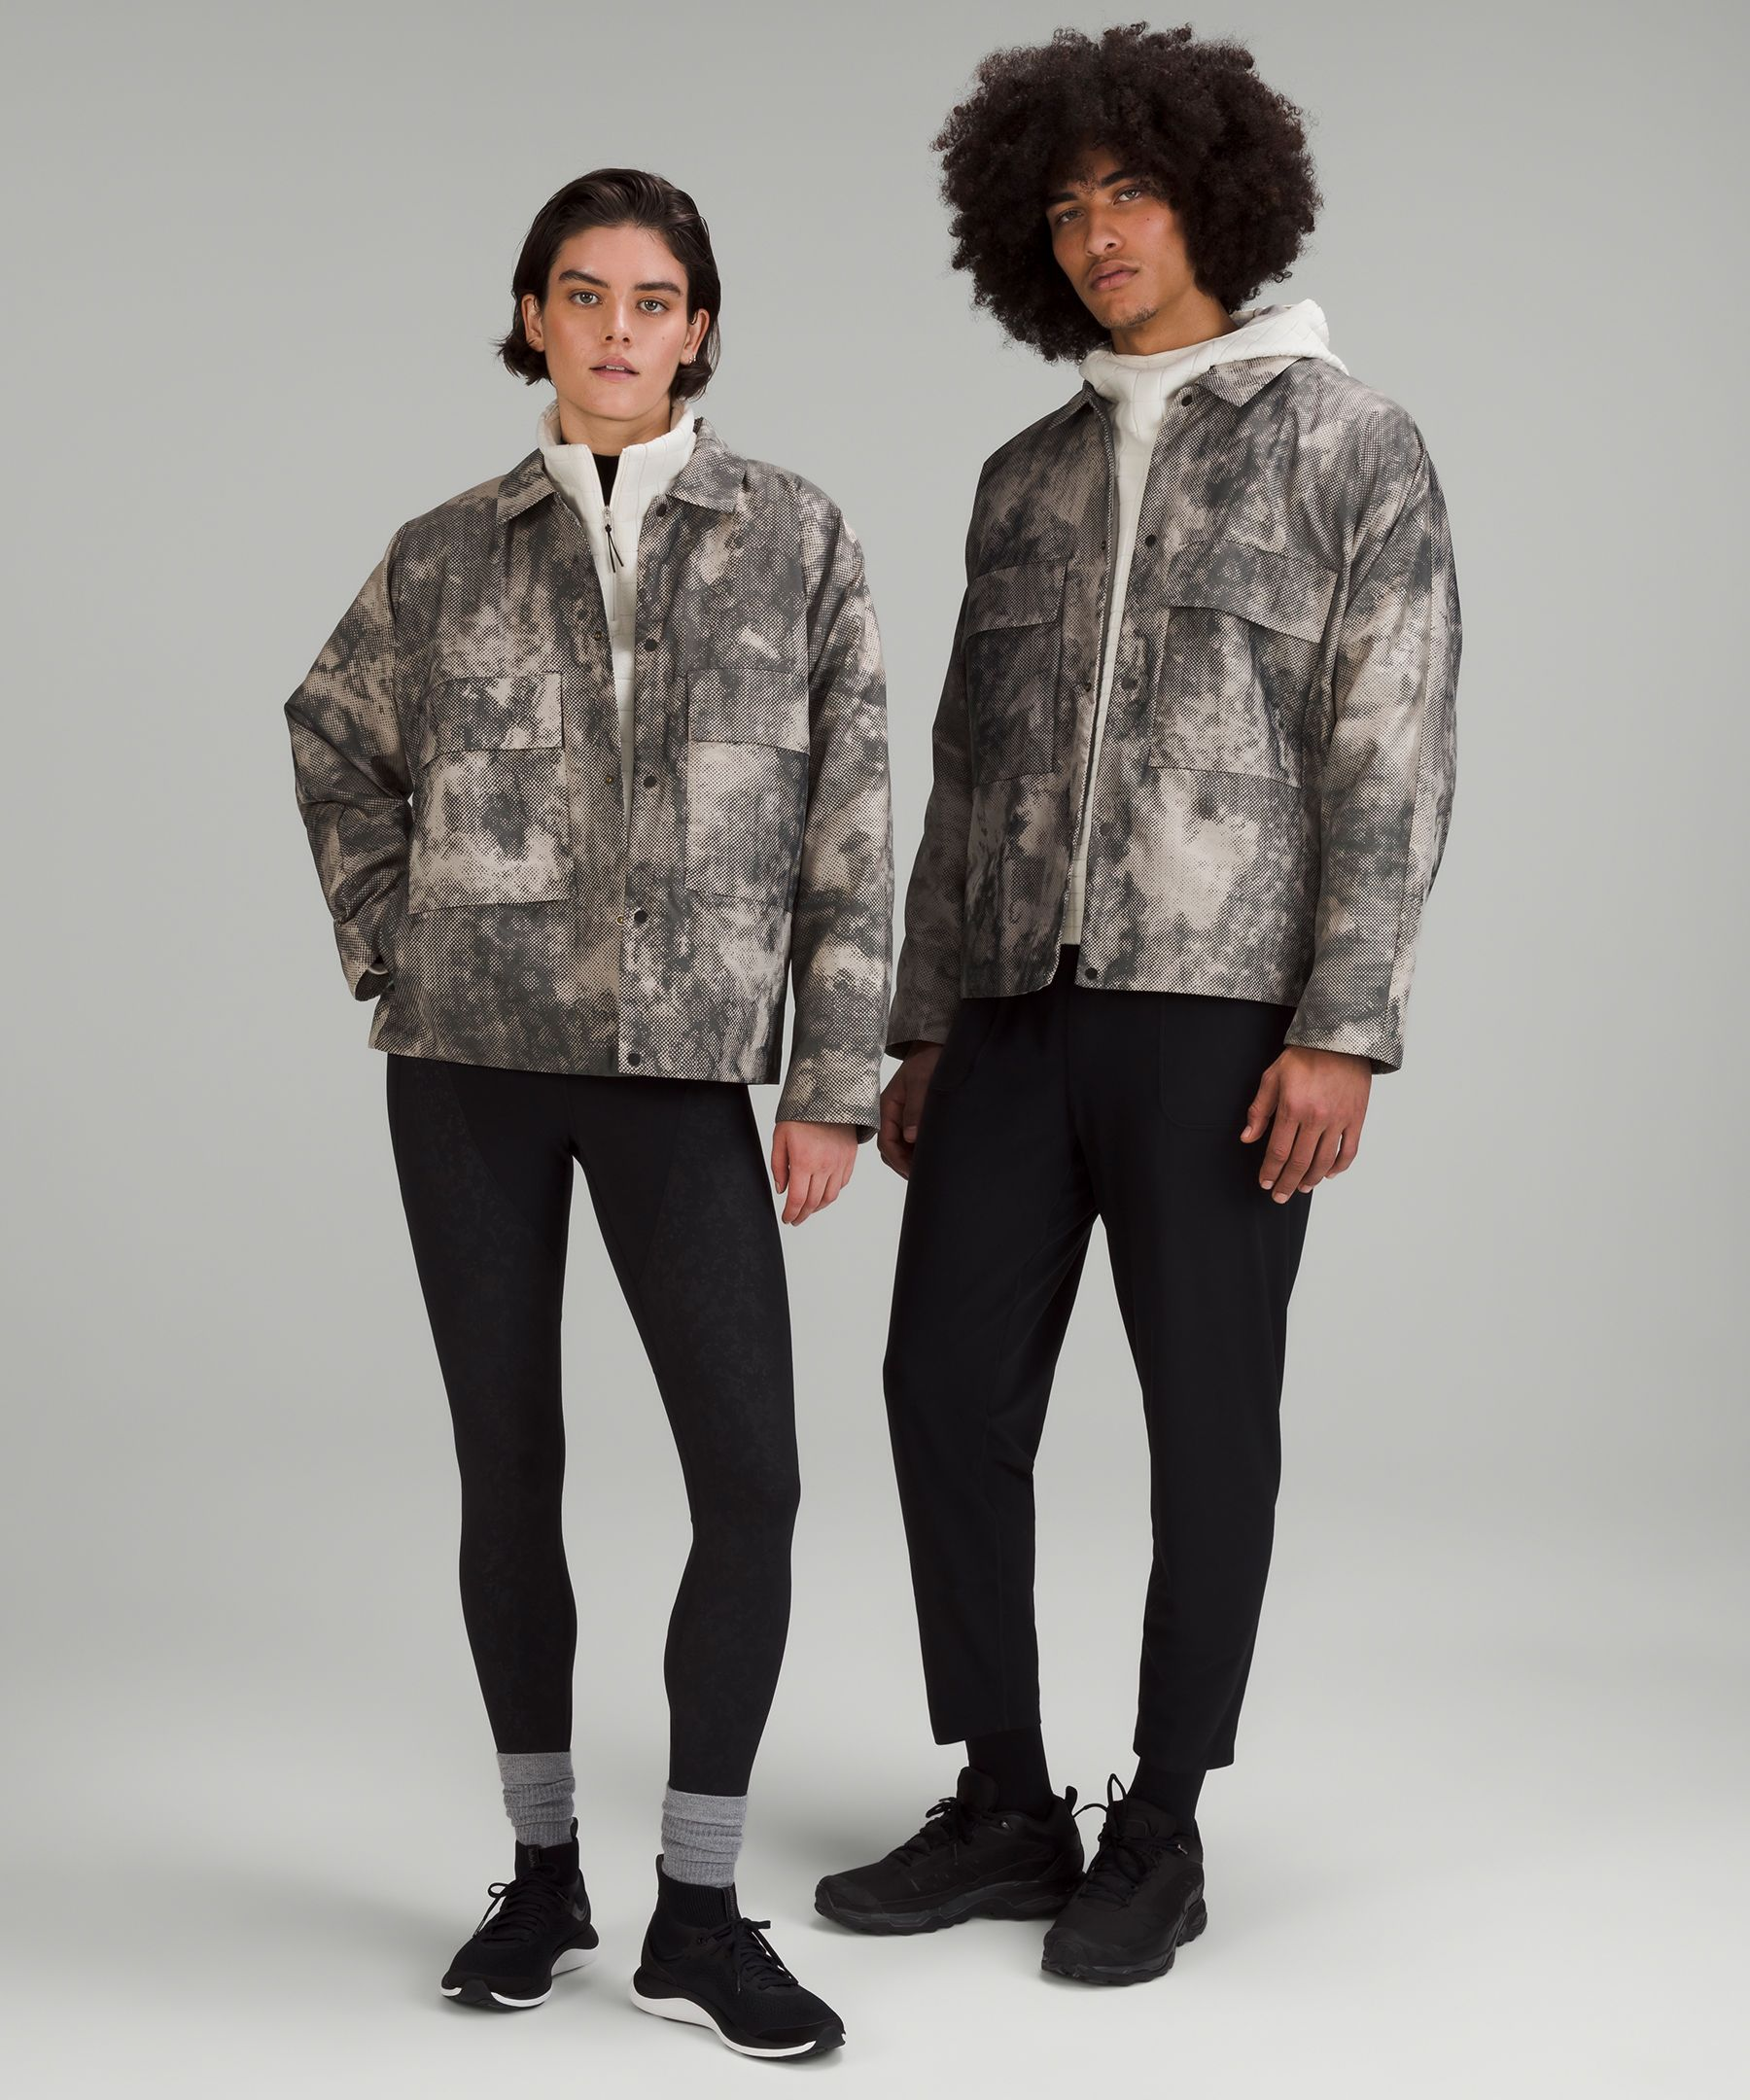

In [8]:
import json
import numpy as np
from fashion_clip.fashion_clip import FashionCLIP
from PIL import Image
import requests
from io import BytesIO

# Load the Fashion-CLIP model
fclip = FashionCLIP('fashion-clip')

# Load your data
with open('data/items_with_embeddings.json', 'r') as f:
    items = json.load(f)

# Define a comprehensive list of potential tags with categories
potential_tags = {
    "Item types": ["dress", "skirt", "pants", "shorts", "t-shirt", "blouse", "sweater", "jacket", "coat", "hoodie",
                   "jeans", "leggings", "jumpsuit", "romper", "blazer", "suit", "shirt", "tank top", "cardigan"],
    "Colors": ["red", "blue", "green", "yellow", "purple", "pink", "orange", "brown", "black", "white",
               "gray", "beige", "navy", "teal", "maroon", "olive", "turquoise", "indigo", "magenta", "coral"],
    "Materials": ["cotton", "polyester", "silk", "wool", "leather", "denim", "linen", "velvet", "satin", "chiffon",
                  "lace", "nylon", "spandex", "cashmere", "tweed", "corduroy", "suede", "fleece", "jersey", "flannel"],
    "Patterns": ["striped", "polka dot", "floral", "plaid", "checkered", "solid", "printed", "geometric"],
    "Styles": ["casual", "formal", "business", "vintage", "bohemian", "preppy", "sporty", "elegant", "minimalist"],
    "Features": ["sleeveless", "long-sleeved", "short-sleeved", "v-neck", "crew neck", "turtleneck", "off-shoulder",
                 "high-waisted", "low-rise", "fitted", "loose", "cropped", "maxi", "mini", "midi", "pleated", "ruffled"],
    "Occasions": ["everyday", "workwear", "party", "beachwear", "activewear", "loungewear", "nightwear"]
}

def extract_tags_from_image(image_url, image_embedding):
    # Flatten the potential_tags dictionary
    all_tags = [tag for category in potential_tags.values() for tag in category]
    
    # Encode potential tags
    tag_prompts = [f"a photo of {tag}" for tag in all_tags]
    tag_embeddings = fclip.encode_text(tag_prompts, batch_size=32)
    tag_embeddings = tag_embeddings / np.linalg.norm(tag_embeddings, ord=2, axis=-1, keepdims=True)
    
    # Compare image embedding with tag embeddings
    similarities = np.dot(tag_embeddings, image_embedding)
    
    # Create a dictionary to store top tags for each category
    top_tags = {}
    
    # Get top two tags for each category
    for category, tags in potential_tags.items():
        category_scores = [(tag, float(similarities[all_tags.index(tag)])) for tag in tags]
        category_scores.sort(key=lambda x: x[1], reverse=True)
        top_tags[category] = category_scores[:2]
    
    return top_tags

# Function to load image from URL
def load_image_from_url(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert('RGB')

# Example usage
item_id = "2"  # Use the ID of the item you want to analyze
item = items[item_id]
image_url = item['image_urls'][0]
image_embedding = np.array(item['image_embedding'])

# Extract tags
tags = extract_tags_from_image(image_url, image_embedding)

print(f"Item name: {item['product_name']}, Item image: {image_url}")
print("Top 2 tags for each category:")
for category, top_tags in tags.items():
    print(f"\n{category}:")
    for tag, score in top_tags:
        print(f"  {tag}: {score:.4f}")

# You can also visualize the image
image = load_image_from_url(image_url)
# image.show()
image

In [27]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Load the Fashion-CLIP model and embeddings (if not already loaded)
fclip = FashionCLIP('fashion-clip')
with open('data/items_with_embeddings.json', 'r') as f:
    items_with_embeddings = json.load(f)

image_embeddings = np.array([item['image_embedding'] for item in items_with_embeddings.values()])

def find_matching_item(query):
    text_embedding = fclip.encode_text([query], 32)[0]
    id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
    
    matched_item = list(items_with_embeddings.values())[id_of_matched_object]
    
    # Display the matched item's information
    print(f"Matched item: {matched_item['product_name']}")
    print(f"Brand: {matched_item['brand']}")
    print(f"Description: {matched_item['long_description']}")
    
    # Display the image if available
    if matched_item['image_urls']:
        image_url = matched_item['image_urls'][0]
        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content))
            
            # Resize the image
            fixed_height = 224
            height_percent = (fixed_height / float(image.size[1]))
            width_size = int((float(image.size[0]) * float(height_percent)))
            image = image.resize((width_size, fixed_height), Image.NEAREST)
            
            return image
        except Exception as e:
            print(f"Error loading image: {e}")
            return None
    else:
        print("No image available for this item.")
        return None

# Example usage
query = "pink striped pants"
result_image = find_matching_item(query)

if result_image:
    result_image.show()  # This will display the image if you're in a Jupyter notebook

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 23.59it/s]


Matched item: Pink Mini Stripe Slim Wrinkle-Resistant Dress Shirt
Brand: Banana Republic
Description: Designed for ease of wear and care, this sleek dress shirt employs a special cotton fabric with PUREPRESS™ cotton technology, a special process that smooths and protects the fabric, resulting in a wrinkle-resistant finish. Slim fit with darts at the back. Spread collar. Shirttail hem. Slim fit. Long sleeves. Hip length. Model: Size M, 6'2" (188cm). 100% cotton.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
